In [2]:
from dataset import CUBDataset, FGVCAircraft, FOODDataset
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torch.utils.data import ConcatDataset 
import torch
from torch.utils.data import default_collate

from matplotlib import pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
num_classes = 200


transforms_train = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=(0.9, 1.0), antialias=True),

    # v2.AutoAugment(policy=v2.AutoAugmentPolicy.IMAGENET, ),
    v2.RandAugment(num_ops=4, magnitude=10),
    v2.RandomErasing(p=0.1),

    v2.ToDtype(torch.float, scale=True),
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
])
# transforms_train = v2.Compose([
#     v2.ToImage(),
# ])

transforms_test = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224), antialias=True),
        v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    ])

cutmix = v2.CutMix(num_classes=num_classes, alpha=1.0)
mixup = v2.MixUp(num_classes=num_classes, alpha=0.2)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

In [8]:
dataset_name = 'FoodX'

if dataset_name == 'CUB':
    dataset_path = "datasets/CUB/CUB_200_2011"

    train_dataset = CUBDataset(image_root_path=dataset_path, transform=transforms_train, split="train")
    test_dataset = CUBDataset(image_root_path=dataset_path, transform=transforms_test, split="test")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

    class_names = train_dataset.classes

elif dataset_name == 'CUB and FGVC-Aircraft':
    dataset_path_cub = "datasets/CUB/CUB_200_2011"
    train_dataset_cub = CUBDataset(image_root_path=dataset_path_cub, transform=transforms_train, split="train")
    test_dataset_cub = CUBDataset(image_root_path=dataset_path_cub, transform=transforms_test, split="test")

    dataset_path_aircraft = "datasets/fgvc-aircraft-2013b"
    train_dataset_aircraft = FGVCAircraft(root=dataset_path_aircraft, transform=transforms_train, train=True)
    test_dataset_aircraft = FGVCAircraft(root=dataset_path_aircraft, transform=transforms_test, train=False)

    concat_dataset_train = ConcatDataset([train_dataset_cub, train_dataset_aircraft])
    concat_dataset_test = ConcatDataset([test_dataset_cub, test_dataset_aircraft])

    train_loader = torch.utils.data.DataLoader(
                concat_dataset_train,
                batch_size=BATCH_SIZE, shuffle=True,
                num_workers=8, pin_memory=True
                )
    test_loader = torch.utils.data.DataLoader(
                concat_dataset_test,
                batch_size=BATCH_SIZE, shuffle=False,
                num_workers=8, pin_memory=True
                )
    
    classes_1 = concat_dataset_train.datasets[0].classes
    classes_2 = concat_dataset_train.datasets[1].classes

    class_names = [*classes_1, *classes_2]

elif dataset_name == 'FoodX':
    dataset_path = "datasets/FoodX/food_dataset"

    train_dataset = FOODDataset(data_dir=dataset_path, transform=transforms_train, split="train")
    test_dataset = FOODDataset(data_dir=dataset_path, transform=transforms_test, split="val")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

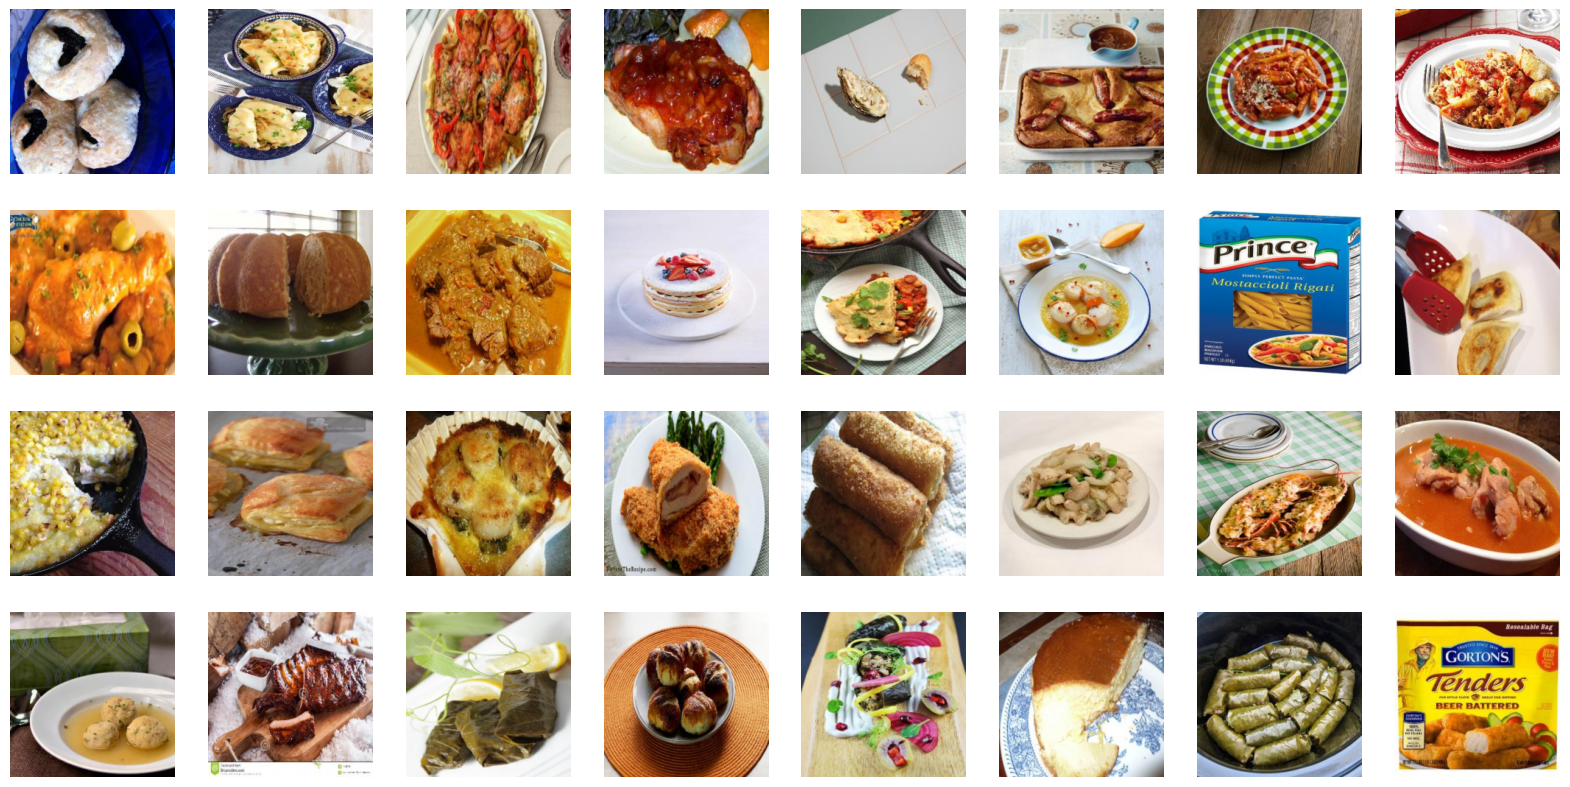

In [11]:
# plot batch of images
def plot_batch(batch):
    images, labels = batch
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        image = images[i].permute(1, 2, 0)
        # remove normalization
        image = image * torch.tensor([0.229,0.224,0.225]) + torch.tensor([0.485,0.456,0.406])
        ax.imshow(image)

        # label = labels[i].item()
        # label = class_names[label]
        # ax.set_title(label)
        ax.axis('off')
    plt.show()

plot_batch(next(iter(test_loader)))

In [13]:
print(len(concat_dataset_test))
print(len(concat_dataset_train))

9127
12661


In [15]:
labels = [label for _, label in concat_dataset_train]

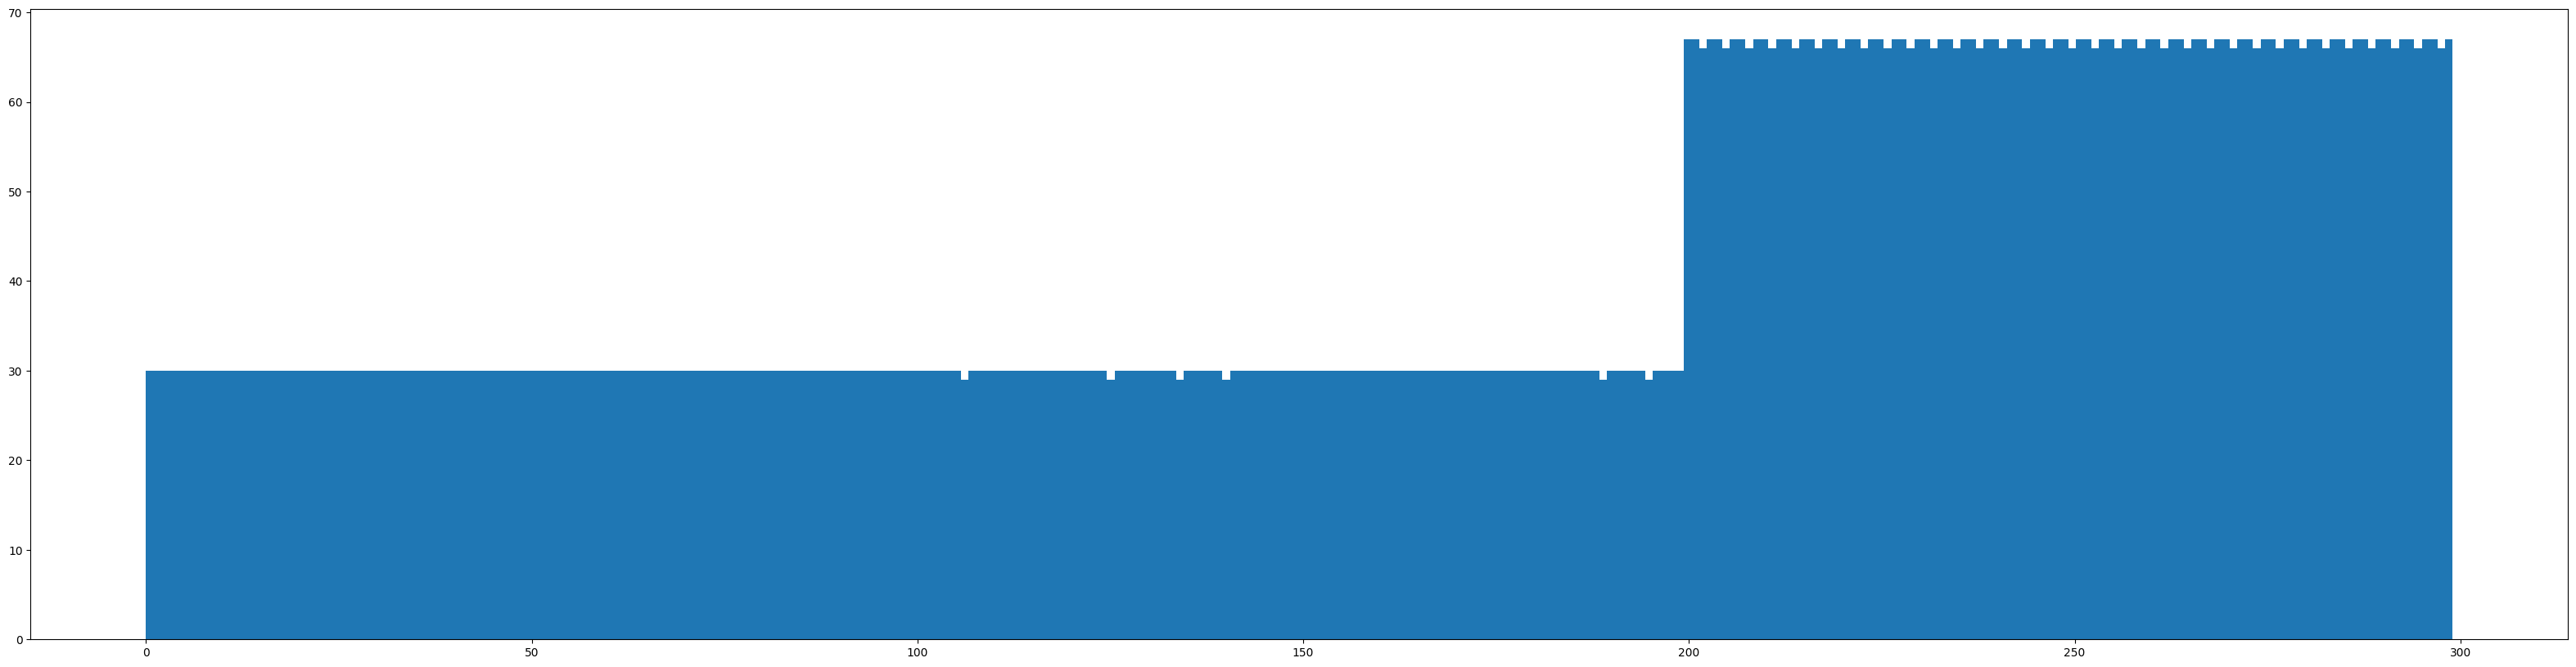

In [16]:
# show class distribution

plt.figure(figsize=(40, 10))

plt.hist(labels, bins=len(class_names))
# plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.show()

